# Imports:

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import copy

from pygsp import graphs, filters, reduction, plotting
from scipy import sparse

%matplotlib inline

# Part IV
# Identify the players in each team

In [2]:
adjacency = pd.read_csv("./Data/Adjacencies/adjacency_hyperlinks.csv").values

In [3]:
adjacency_sparsed = sparse.csr_matrix(adjacency)

In [11]:
All_Nodes = pd.read_csv("./Data/All_Nodes.csv", sep='\t', encoding= 'utf-16')

In [4]:
G = graphs.Graph(adjacency_sparsed)
print("Number of nodes: ", str(G.N))

Number of nodes:  800


The nodes are divided into three categories: 736 players, 32 countries and 32 teams

Now lets start with identifying the players in each team. For this we start appling a heat signal on a player of a team, which then ideally transmits the heat to the different team members. In the example below we chose the player with the node 484, which represents "Thomas Müller", a german football player.

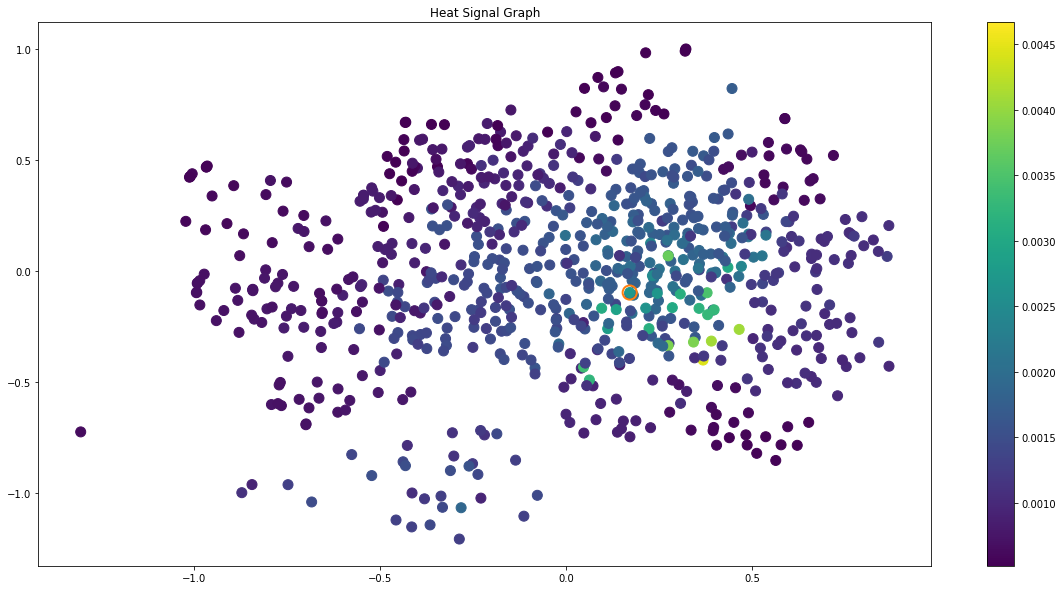

In [111]:
player_delta = 484            # represents Thomas Müller
DELTAS = [player_delta]
s = np.zeros(G.N)
s[DELTAS] = 1
G.estimate_lmax()
g = filters.Heat(G, tau=30)
s = g.filter(s)

fig, ax = plt.subplots(figsize=(20, 10))
G.set_coordinates()
plotting.plot_signal(G, s, highlight=DELTAS ,backend= 'matplotlib',ax = ax, \
                     plot_name = 'Heat Signal Graph', vertex_size =100)

In the graph above we can see the heat signal on the network of hyperlinks where each player is connected to the page of the team. The heat signal is highlighted in with a orange circle. 

In order to identify the players in each team we have set a threshold that reduces the amount of results to a maximum of maxplayers, because each team has maximum number of players!

In [112]:
# Set threshold for percentage
def set_threshold(s, maxplayer):
    s_sorted = np.sort(s)
    n = len(s_sorted)
    threshold = s_sorted[n-maxplayer]
    
    return threshold

In [113]:
# Identify players with with heat kernal
def identify_players():
    n = G.N 
    maxplayer = 19
    players_graphbased = []
    threshold = set_threshold(s, maxplayer)
    for i in range(n):
        if (s[i] > threshold):
            players_graphbased.append(i)
    print(players_graphbased)
    
    return players_graphbased

In [114]:
players_graphbased = identify_players()

[92, 104, 183, 251, 260, 265, 279, 302, 315, 372, 551, 570, 588, 589, 661, 674, 685, 718]


In [115]:
All_Nodes.iloc[player_delta, :]

Node        Thomas Müller
Category           player
Name: 484, dtype: object

Lets see the results of this graph analyse:

In [116]:
All_Nodes.iloc[players_graphbased, :]

,Node,Category
92,Jérôme Boateng,player
104,Julian Brandt,player
183,Julian Draxler,player
251,Matthias Ginter,player
260,Mario Gómez,player
265,Leon Goretzka,player
279,İlkay Gündoğan,player
302,Jonas Hector,player
315,Mats Hummels,player
372,Joshua Kimmich,player


That is a pretty good result. When comparing the result with the actual team players we got a accuary of 100 percent (when only choosing 19 players in total). If we add a lower threshold the accuary goes down respectly. In the next step we will see that this method also works if we apply a delta signal on the countries.

In [117]:
country_delta = 737            # represents Germany
DELTAS = [country_delta]
s_country = np.zeros(G.N)
s_country[DELTAS] = 1
G.estimate_lmax()
g = filters.Heat(G, tau=30)
s = g.filter(s_country)

In [118]:
players_graphbased = identify_players()

[92, 104, 183, 251, 260, 265, 279, 302, 315, 372, 551, 570, 588, 589, 661, 674, 685, 718]


In [119]:
All_Nodes.iloc[players_graphbased, :]

,Node,Category
92,Jérôme Boateng,player
104,Julian Brandt,player
183,Julian Draxler,player
251,Matthias Ginter,player
260,Mario Gómez,player
265,Leon Goretzka,player
279,İlkay Gündoğan,player
302,Jonas Hector,player
315,Mats Hummels,player
372,Joshua Kimmich,player


As a result we can see that with applying the heat filter we can identify the teams pretty good. 

*(Maybe add some more here...)*